In [28]:
#!pip install seaborn
#!pip install openpyxl
#!pip install pmdarima

In [29]:
import pandas as pd
import numpy as np
import random as rd
import time
import csv
import seaborn as sbs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split ,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from pmdarima.arima import auto_arima
from pmdarima.arima import StepwiseContext
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error


In [30]:
# fix random seed for reproducibility
tf.random.set_seed(9)

In [31]:
# #from google.colab import drive
#drive.mount('/content/drive')
file_data = 'lynx.csv'
path_name='../datasets/'
path_name_results='../results/'
file_result = 'Result_ARIMA_canadian_lynx.csv'

In [32]:

dataset = pd.read_csv(f'{path_name}{file_data}', sep =',', encoding = 'latin1', decimal='.',usecols=[1,2])
dataset.columns = ['date','num_observations']
#dataset.columns = ['month','year', 'value']
#dataset.values
#dataset = pd.read_csv(f'{path_name}{file_data}', sep =',', encoding = 'latin1', decimal='.')
#dataset.columns = ['year','month', 'date','total_sunspot_number','std_derivation','num_observations','def_prov_indicator']
#dataset.head()



In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   date              114 non-null    int64
 1   num_observations  114 non-null    int64
dtypes: int64(2)
memory usage: 1.9 KB


In [34]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

date                0
num_observations    0
dtype: int64

In [35]:
def salvar_resultado(nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration):
  #Script to write training cycle results
  data = [nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration]
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE', 'MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "a",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(data)  
  print(fields)
  print(data)
    
#Script to create the results file
def criar_arquivo_resultado():
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE','MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "w",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(fields)    

In [36]:
# convert an array of values into a dataset matrix
def create_matrix_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return np.array(df.drop(columns=['date','vl_0'])), np.array(df['vl_0'])

# convert dataset values into a dataset matrix
def create_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return df

In [37]:
  
def save_model(model,n_time_steps):
  # serialize model to JSON
  model_json = model.to_json()
  with open(f'{path_name_results}model_{n_time_steps}.json', "w") as json_file:
    json_file.write(model_json)

  # serialize weights to HDF5
  model.save_weights(f'{path_name_results}model_{n_time_steps}.h5')
  print("Saved model to disk")


In [38]:
def gera_resultado(y_test, predict,nm_dataset, resultado, n_time_steps, Duracao):
 #Mean Squared Error (Mean Squared Difference Between Estimated Values and Actual Values) - MSE
 MSE = mean_squared_error(y_test, predict)    
 #Square Root of Mean Error - RMSE
 RMSE = np.sqrt(mean_squared_error(y_test, predict))    
 #Mean Absolute Distance or Mean Absolute Error - MAE
 MAE= median_absolute_error(y_pred=predict, y_true = y_test) 
  
 #Calculate the MAPE (Mean Absolute Percentage Error)
 MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100   
  
 sMAPE = round(
 	np.mean(
 		np.abs(predict - y_test) /
 		((np.abs(predict) + np.abs(y_test)))
 	)*100, 2
 ) 
 salvar_resultado(nm_dataset, resultado, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duracao)
 return MAPE

array([<AxesSubplot:xlabel='date'>], dtype=object)

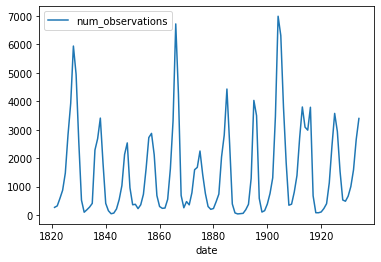

In [39]:
# indexing timestamp
dataset.set_index('date').plot(subplots=True)

In [40]:
def previsao_ARIMA(nm_dataset, dataset, n_time_steps, max_iter): 
    
 #Split dataset in treinam /  80% treinam  20% test
 nlinhas = int(len(dataset) * 0.80)
 test = dataset.iloc[nlinhas:len(dataset),:]  
 train = dataset.iloc[0:nlinhas,:] 
 #  reshape into X=t and Y=t+1 ot n_time_steps by steps
 X_train, Y_train = create_matrix_dataset(train, n_time_steps)
 X_test, Y_test = create_matrix_dataset(test, n_time_steps)  

 # indexing timeserires
 ts_df=create_dataset(dataset, n_time_steps)
 ts_df.set_index('date').plot(subplots=True) 

 Y_train = Y_train.reshape(-1,1)
 Y_test=Y_test.reshape(-1,1) 

 # Armazena a hora de início da execução do Treinamento
 Hora_Inicio = time.time() 

 # Estimate the differences number using ADF test
 # significance level alpha=0.05
 ADF_test = ADFTest(alpha=0.05)
 p_val, should_diff = ADF_test.should_diff(Y_train)   

 if(should_diff):  # if  should_diff is true 
     d = ndiffs(Y_train, test='adf') 
 else: # if  should_diff is False
     d=0 

 # autocorrelation test
 pm.plot_acf(Y_train) 

 # Search for best ARIMA hiperparams.
 with StepwiseContext(max_dur=50):
    model = auto_arima(Y_train, X = X_train,
                       seasonal=True, m=12, maxiter=500, d=0, 
                       start_p=0, start_q=0, max_p=9, max_q=9, 
                       D=None, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True) 

 #print(model.params)
 model.fit(Y_train)
 resultado = model 

 # predictiong values
 predict=model.predict(n_periods=Y_test.shape[0], X=X_test, alpha=0.05)
 predict=predict.reshape(-1,1) 

 Hora_Fim = time.time()    
 

 #print real x predict
 df_predict = pd.DataFrame(predict)
 new_df=pd.DataFrame()
 total=nlinhas+len(df_predict)
 new_df['real']=(dataset.iloc[0:total,1])
 new_df['date']=dataset.iloc[0:total,0]
 new_df['predict']=pd.concat([dataset.iloc[0:nlinhas,1],df_predict],ignore_index=True)
 new_df.set_index('date').plot() 

 #Calculate the duration of the training execution
 Duracao = Hora_Fim - Hora_Inicio    

 #calc metrics of error and save in file
 gera_resultado(Y_test, predict,nm_dataset, resultado, n_time_steps, Duracao)

forecast for canadian lynx


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


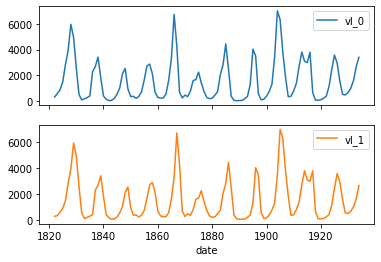

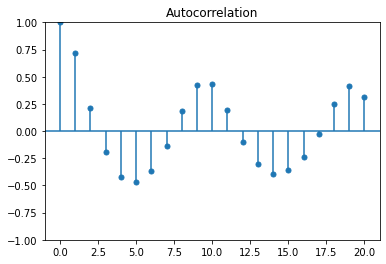

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1528.058, Time=0.34 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1507.622, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1497.948, Time=1.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1532.972, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1497.502, Time=0.38 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1498.679, Time=0.86 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1496.051, Time=0.58 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1497.337, Time=1.67 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1496.845, Time=1.39 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1506.946, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1489.846, Time=0.42 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept

c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (52.975 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(2, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 2, 12), suppress_warnings=True), 1, 1133072.4484493842, 1064.458758453978, 768.2678431379995, 168.43986123755008, 33.61, 55.35192346572876]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


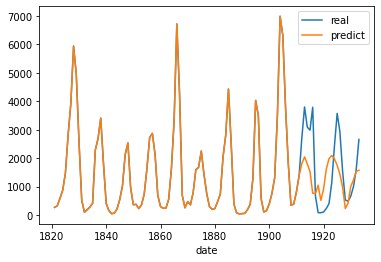

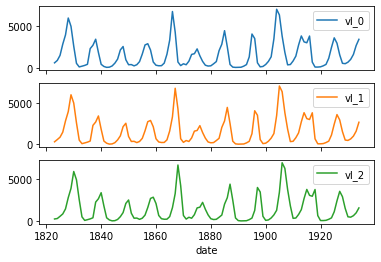

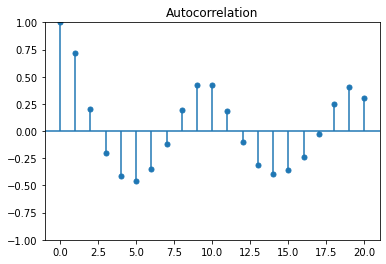

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1470.689, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1472.784, Time=1.55 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1471.427, Time=1.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1492.152, Time=0.23 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1470.816, Time=1.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1470.790, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1472.073, Time=0.46 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1474.010, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1473.000, Time=0.51 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 8.466 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=Tr

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


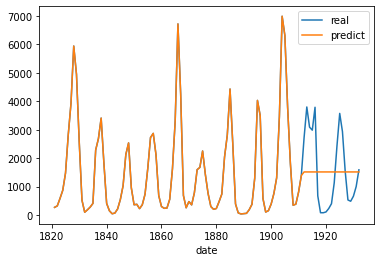

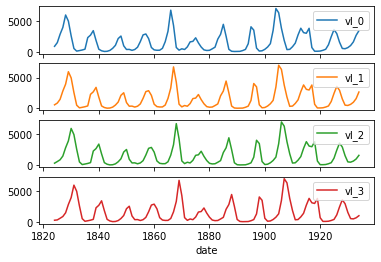

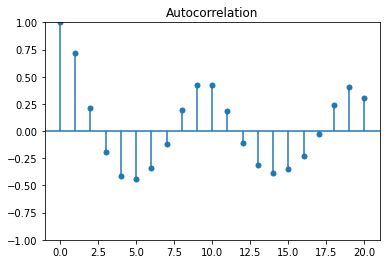

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1456.132, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1456.505, Time=0.52 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1459.187, Time=5.61 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1458.628, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1472.691, Time=0.43 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1465.324, Time=0.42 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1465.841, Time=0.40 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1457.822, Time=4.49 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=11.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.70 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=9.72 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, 

c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (56.106 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 1, 12), suppress_warnings=True), 3, 771588.6454011692, 878.40118704449, 781.5366609295723, 208.7007715702522, 33.03, 58.24079632759094]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


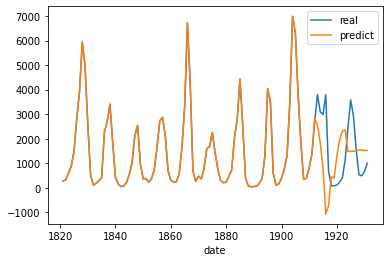

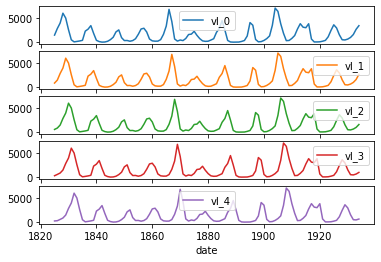

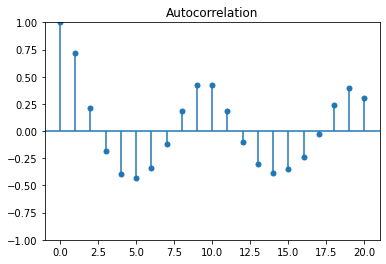

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1438.921, Time=0.45 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1439.175, Time=3.63 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1442.308, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1458.972, Time=0.36 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1437.754, Time=1.72 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1441.870, Time=2.77 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1437.408, Time=2.07 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=5.03 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=4.90 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1438.737, Time=3.27 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1442.518, Time=1.10 sec
 ARIMA(0,0,0)(0,0,1)[12]             : AIC=1460.957, Time=0.63 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 30.135 seconds
['Dataset', 'Best Para

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


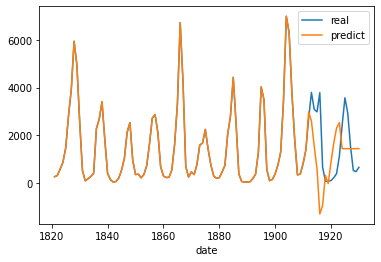

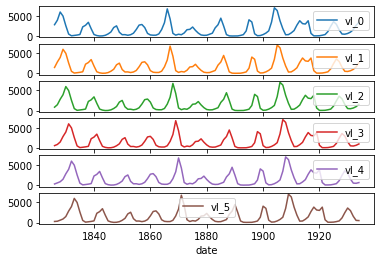

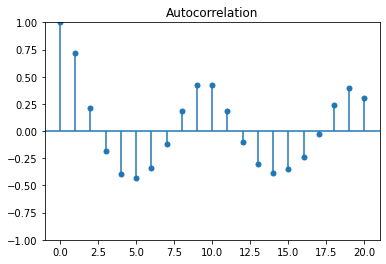

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1423.581, Time=0.60 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1438.182, Time=1.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1425.643, Time=1.34 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1443.048, Time=0.57 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1423.729, Time=2.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1437.835, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1436.770, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1425.345, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1425.578, Time=0.66 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 9.987 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=Tr

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


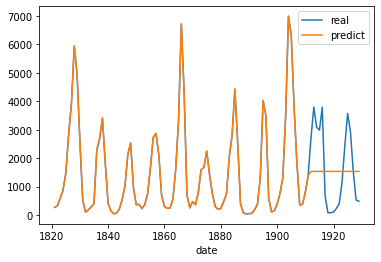

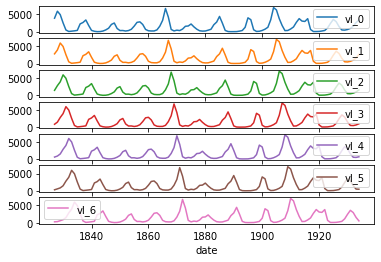

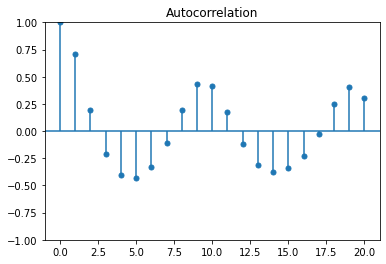

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1422.892, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1410.023, Time=0.35 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1421.990, Time=0.96 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1408.580, Time=2.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1425.412, Time=0.46 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1408.516, Time=0.57 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1409.004, Time=1.31 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1411.016, Time=2.99 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1409.168, Time=1.00 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1421.192, Time=0.53 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=5.77 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=1412.022, Time=1.12 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 21.423 seconds
['Dataset', 'Best

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


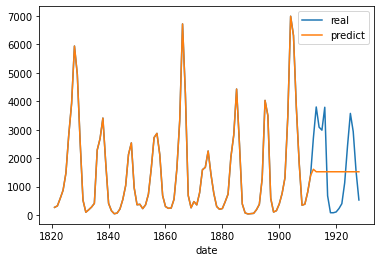

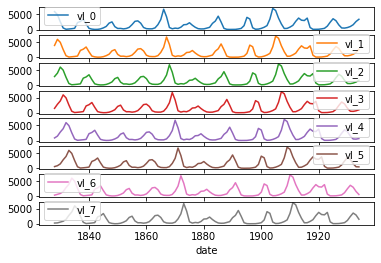

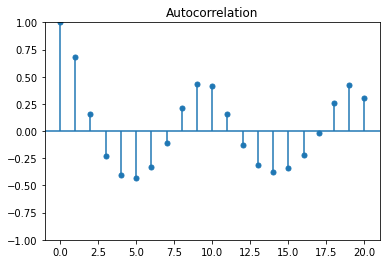

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1405.111, Time=2.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1402.066, Time=0.27 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1385.994, Time=3.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1391.197, Time=2.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1403.095, Time=0.66 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1384.159, Time=0.60 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1386.037, Time=2.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1385.395, Time=7.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1384.916, Time=0.85 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1400.719, Time=1.46 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1389.450, Time=0.83 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1386.052, Time=1.80 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=1383.877, Time=0.71 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=1385.738, Time=3.04 sec
 ARIMA(1,0,0)(0,0,1

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


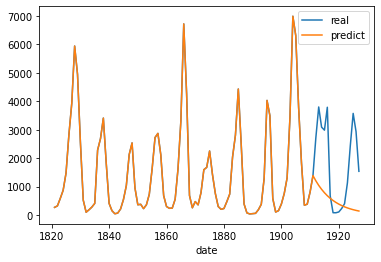

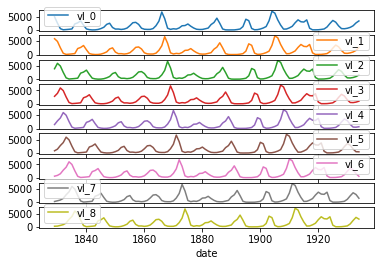

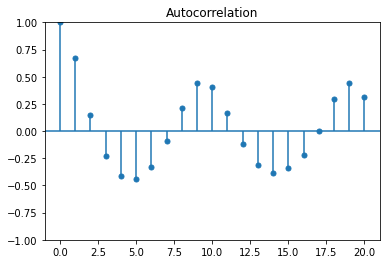

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1364.323, Time=0.17 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1367.233, Time=1.71 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1367.087, Time=1.56 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1363.306, Time=0.70 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1366.320, Time=0.62 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1366.323, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1365.236, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1365.109, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1367.110, Time=1.34 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 10.324 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=T

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


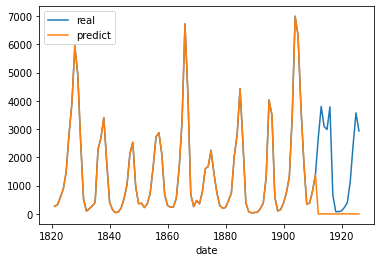

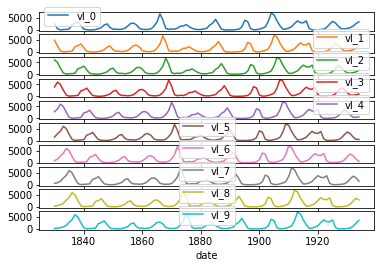

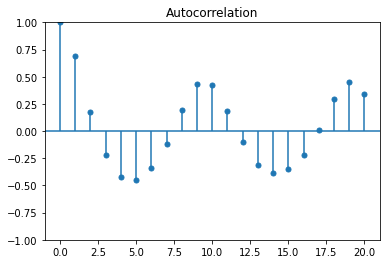

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1349.690, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1353.683, Time=1.49 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1353.660, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1348.376, Time=0.84 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1351.669, Time=0.61 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1351.649, Time=0.74 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1351.701, Time=0.57 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1351.701, Time=0.53 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1350.765, Time=1.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 10.194 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=T

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


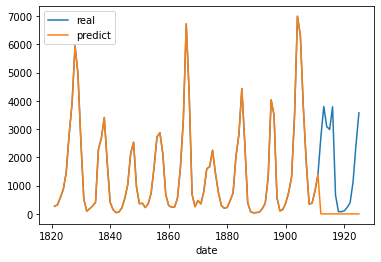

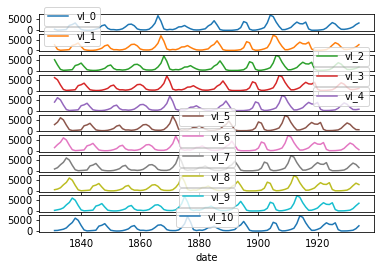

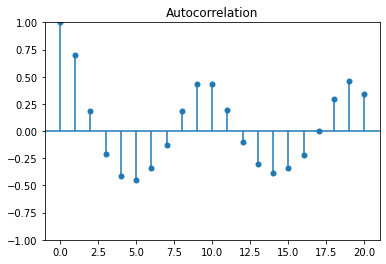

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1336.430, Time=0.21 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1340.187, Time=3.01 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1335.223, Time=13.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1335.144, Time=0.96 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1338.415, Time=0.75 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1338.397, Time=0.76 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1338.190, Time=1.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=6.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1335.686, Time=3.47 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 33.680 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True,

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


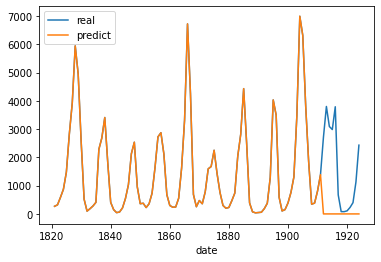

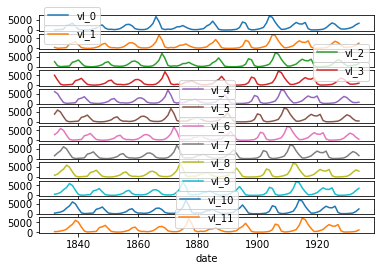

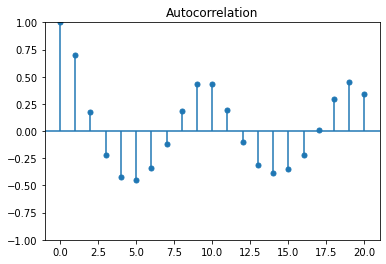

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=5.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1320.357, Time=0.36 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1323.978, Time=2.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1323.993, Time=2.58 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1319.360, Time=0.87 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1322.086, Time=1.18 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1322.140, Time=1.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1322.249, Time=0.84 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1322.206, Time=0.80 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=5.58 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 20.839 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True,


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


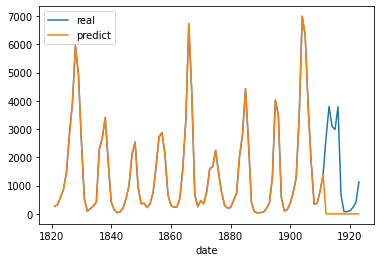

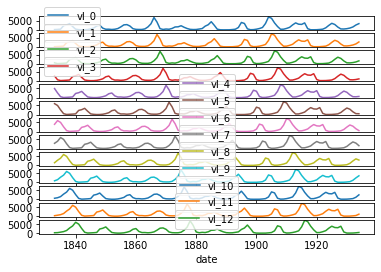

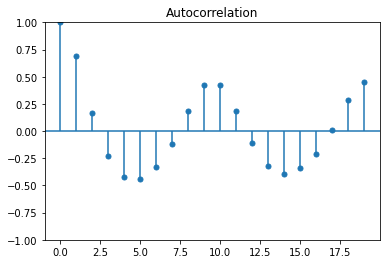

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=5.21 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1307.049, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1310.749, Time=2.91 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1305.490, Time=18.48 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1305.925, Time=1.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1303.609, Time=6.21 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1305.340, Time=20.94 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1306.580, Time=19.86 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=10.00 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=1304.875, Time=9.94 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1308.986, Time=0.74 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1307.485, Time=8.90 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=1307.935, Time=0.80 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 105.465 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (105.442 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['c.lynx', ARIMA(maxiter=500, order=(0, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 12, 1441240.4490819054, 1200.516742524612, 893.3000222703242, 70.83806610147177, 30.17, 108.416574716568]


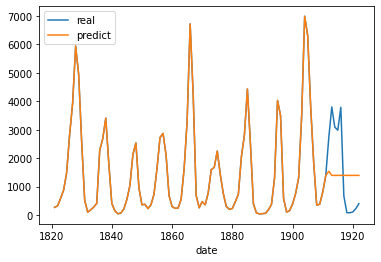

In [41]:
#create file to results
criar_arquivo_resultado()

print('forecast for canadian lynx')
max_iter =500 # number of epochs for train


for n_time_steps in range(1,13): #predict with 1 to 12 past values of medition 
   previsao_ARIMA('c.lynx', dataset, n_time_steps, max_iter)